In [1]:
import pickle

model_output_path = "/home/yuanhong/Documents/im2Flow2Act/im2flow2act/experiment/3D_flow_generation/coffee/2025-04-09_18-16-21/evaluations/epoch_2000/outputs.pickle"
with open(model_output_path, "rb") as handle:
    output = pickle.load(handle)

output["generated_flow"] = output["generated_flow"].cpu().numpy()
output["point_tracking_sequence"] = output["point_tracking_sequence"].cpu().numpy()

In [2]:
import numpy as np
print(output.keys())
mse = (output["generated_flow"] - output["point_tracking_sequence"]) ** 2
mse.sum() / 50

dict_keys(['global_obs', 'first_frame_object_points', 'point_tracking_sequence', 'generated_flow'])


7630.750917541815

In [3]:
print(output["first_frame_object_points"][:,:,:3].permute(0, 2, 1).shape)
output["generated_flow"].shape

torch.Size([50, 3, 30])


(50, 3, 50, 30)

In [4]:
original = output["generated_flow"].copy()
output["generated_flow"][:, :, 0, :] = output["first_frame_object_points"][:,:,:3].permute(0, 2, 1)
output["generated_flow"] = np.cumsum(output["generated_flow"], axis=2)

In [5]:
# Let's found out how many trajectories are diverging, biased, and correct
from numpy.linalg import norm
from einops import rearrange

diverge_idx = []
bias_idx = []
correct_idx = []

N_traj = output["generated_flow"].shape[0]

for i in range(N_traj):
    flow_end = output["generated_flow"][i]
    flow_end = rearrange(flow_end, "c t n -> t n c")[-1]

    gt_end = output["point_tracking_sequence"][i]
    gt_end = rearrange(gt_end, "c t n -> t n c")[-1]
    
    flow_end_mean = flow_end.mean(axis=0)
    de_mean_norm = norm(flow_end - flow_end_mean, axis=1)
    if np.median(de_mean_norm) > 0.05:
        diverge_idx.append(i)
    elif norm(flow_end_mean - gt_end.mean(axis=0)) > 1:
        bias_idx.append(i)
    else:
        correct_idx.append(i)

In [6]:
print(len(diverge_idx))
print(len(bias_idx))
print(len(correct_idx))

8
42
0


In [10]:
idx = np.random.choice(diverge_idx)
# idx = 33
pcd = output["global_obs"][idx]
flow_3d = output["generated_flow"][idx]
flow_3d = rearrange(flow_3d, "c t n -> t n c")

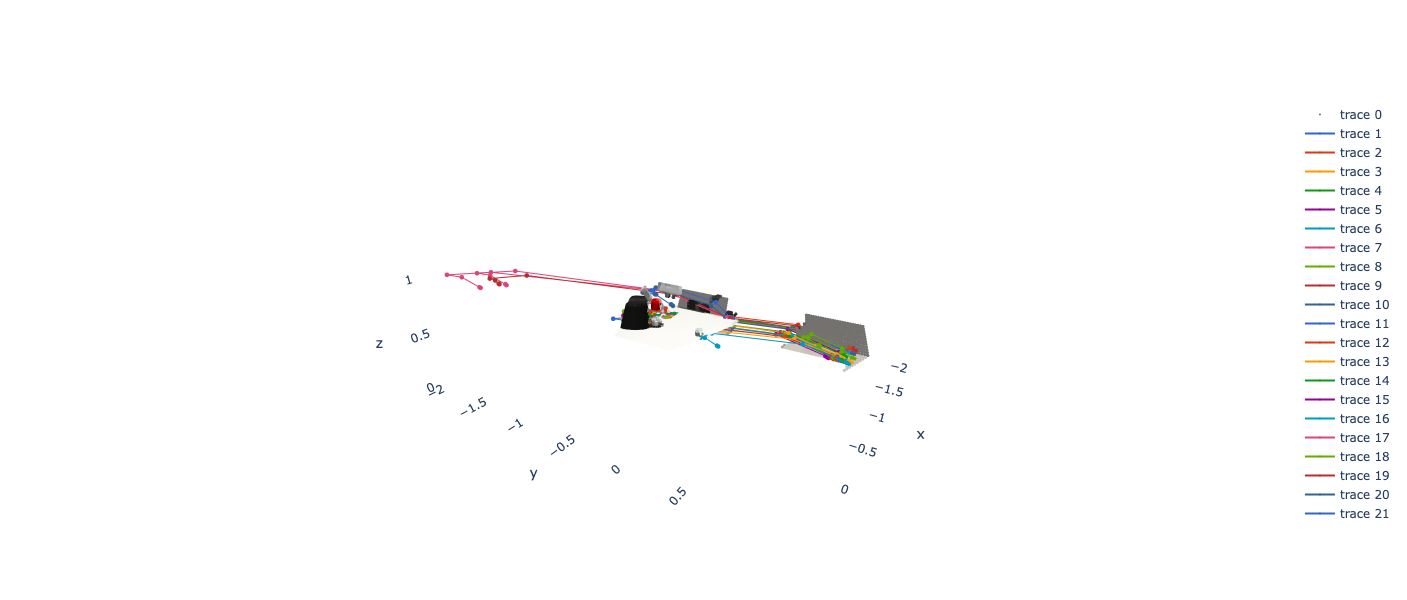

In [11]:
import plotly.graph_objects as go
import plotly.express as px

points = np.asarray(pcd[:, :3])
colors = np.asarray(pcd[:, 3:])

colors_255 = (colors * 255).astype(np.uint8)
hex_colors = [f"rgb({r},{g},{b})" for r, g, b in colors_255]

fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=hex_colors
    )
)])

colors = list(px.colors.qualitative.G10) * 5

# Add each trajectory as a separate trace.
for i in range(flow_3d.shape[1]):
    fig.add_trace(go.Scatter3d(
        x=flow_3d[::5,i,0],
        y=flow_3d[::5,i,1],
        z=flow_3d[::5,i,2],
        mode='markers+lines',
        marker=dict(size=1.5, color=colors[i]),
        line=dict(color=colors[i], width=2),
    ))

fig.update_layout(
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    scene=dict(
        bgcolor='white',
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    )
)
fig.show()

In [9]:
print(idx)

48
